In [19]:
import numpy as np
import pandas as pd
from surprise import Dataset, NormalPredictor, Reader, SVD, accuracy, Trainset

In [20]:
ratings_set_df = pd.read_csv("./data_movie_lens_100k/ratings_all_development_set.csv")
users_df = pd.read_csv("./data_movie_lens_100k/user_info.csv")
movies_df = pd.read_csv("./data_movie_lens_100k/movie_info.csv")

In [21]:
print(ratings_set_df)
print(users_df)
#print(movies_df)

       user_id  item_id  rating
0          772       36       3
1          471      228       5
2          641      401       4
3          312       98       4
4           58      504       5
...        ...      ...     ...
89987      415      813       4
89988      842      120       3
89989      574      505       2
89990      757      472       5
89991      503      204       3

[89992 rows x 3 columns]
     user_id  age  is_male  orig_user_id
0          0   24        1             1
1          1   53        0             2
2          2   23        1             3
3          3   24        1             4
4          4   33        0             5
..       ...  ...      ...           ...
938      938   26        0           939
939      939   32        1           940
940      940   20        1           941
941      941   48        0           942
942      942   22        1           943

[943 rows x 4 columns]


In [22]:
from sklearn.model_selection import train_test_split

ratings_features = ratings_set_df[["user_id", "item_id"]]
ratings = ratings_set_df["rating"]
X_train, X_test, y_train, y_test = train_test_split(ratings_features, ratings)

In [23]:
from train_valid_test_loader import load_train_valid_test_datasets

# Load the dataset in the same way as the main problem 
train_tuple, valid_tuple, test_tuple, n_users, n_items = \
        load_train_valid_test_datasets()


def tuple_to_surprise_dataset(tupl):
    """
    This function convert a subset in the tuple form to a `surprise` dataset. 
    """
    ratings_dict = {
        "userID": tupl[0],
        "itemID": tupl[1],
        "rating": tupl[2],
    }

    df = pd.DataFrame(ratings_dict)

    # A reader is still needed but only the rating_scale param is requiered.
    reader = Reader(rating_scale=(1, 5))

    # The columns must correspond to user id, item id and ratings (in that order).
    dataset = Dataset.load_from_df(df[["userID", "itemID", "rating"]], reader)

    return dataset

## Below we train an SVD model and get its vectors 

# train an SVD model using the training set
trainset = tuple_to_surprise_dataset(train_tuple).build_full_trainset()
test_trainset = tuple_to_surprise_dataset(test_tuple).build_full_trainset()
valid_trainset = tuple_to_surprise_dataset(valid_tuple).build_full_trainset()

In [40]:


def get_features_for_user(user_id):
    return np.array(users_df[users_df["user_id"] == user_id].iloc[0][["age", "is_male"]])

def get_features_for_item(item_id):
    return np.array(movies_df[movies_df["item_id"] == item_id].iloc[0][["release_year"]])

def get_rating(user_id, item_id, features_df: pd.DataFrame):
    return features_df[
        (features_df["user_id"] == user_id) &
            (features_df["item_id"] == item_id)
    ].iloc[0]["rating"]

def get_feature_vectors(data_tuple, svd: SVD, trainset: Trainset):
    user_vectors = svd.pu
    item_vectors = svd.qi
    
    features = np.zeros(
        (
            len(data_tuple[0]),
            user_vectors.shape[1] + item_vectors.shape[1] + len(["age", "is_male"]) + len(["release_year"])
        )
    )
    ratings = []
    for index in range(0, len(data_tuple[0])):
        user_id = data_tuple[0][index]
        item_id = data_tuple[1][index]
        # if trainset.knows_user(user_id):
        try:
            u_i = user_vectors[trainset.to_inner_uid(user_id)]
        except:
            u_i = np.zeros((user_vectors.shape[1]))
        # if trainset.knows_item(item_id):
        try:
            m_j = item_vectors[trainset.to_inner_iid(item_id)]
        except:
            m_j = np.zeros((item_vectors.shape[1]))
        user_features = get_features_for_user(user_id)
        item_features = get_features_for_item(item_id)
        feature_vector = np.concatenate(
            (
                u_i,
                m_j,
                user_features.flatten(),
                item_features.flatten(),
            ),
            axis=0
        )
        features[index] = feature_vector
        
        ratings.append(1 if data_tuple[2][index] > 4 else 0)
    
    return features, ratings


In [25]:

svd_2K = SVD(
    n_factors = 2,
    n_epochs=50
)
svd_10K = SVD(
    n_factors = 10,
    n_epochs=50
)
svd_50K = SVD(
    n_factors = 50,
    n_epochs=50
)

svd_2K.fit(trainset)
svd_10K.fit(trainset)
svd_50K.fit(trainset)
# features_val, ratings_val = get_feature_vectors(valid_tuple, svd, valid_trainset)


In [26]:

features_2K_train, ratings_2K_train = get_feature_vectors(train_tuple, svd_2K, trainset)
features_10K_train, ratings_10K_train = get_feature_vectors(train_tuple, svd_10K, trainset)
features_50K_train, ratings_50K_train = get_feature_vectors(train_tuple, svd_50K, trainset)
features_2K_test, ratings_2K_test = get_feature_vectors(test_tuple, svd_2K, trainset)
features_10K_test, ratings_10K_test = get_feature_vectors(test_tuple, svd_10K, trainset)
features_50K_test, ratings_50K_test = get_feature_vectors(test_tuple, svd_50K, trainset)

In [8]:

# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler

# mlp = MLPClassifier(
# )

# scaler = StandardScaler()
# features_train_scaled = scaler.fit_transform(features_train)

# param_grid = {
#     "solver": ["adam", "sgd"],
#     "activation": ["relu", "tanh"],
#     "hidden_layer_sizes": [(100,), (50,)],
# }

# gs = GridSearchCV(
#     estimator=mlp,
#     param_grid=param_grid,
#     refit=True,
#     return_train_score=True, 
    
# )

# gs.fit(features_train, ratings_train)



In [9]:
# from sklearn.metrics import RocCurveDisplay

 
# roc_disp = RocCurveDisplay.from_estimator(gs.best_estimator_, features_train, ratings_train)

In [10]:
# from sklearn.svm import SVC

# svm = SVC(probability=True)

# param_grid = {
#     'C': [0.1, 1, 10],
#     'gamma': [0.01, 0.1, 1],
#     'kernel': ['rbf']
# }

# gs = GridSearchCV(
#     estimator=svm,
#     param_grid=param_grid,
#     cv=3,
#     scoring='roc_auc',
#     refit=True
# )

# gs.fit(features_train, ratings_train)

# print(gs.best_estimator_)
# print(gs.best_score_)

# # best_svm = SVC(**best_params, probability=True)
# # best_svm.fit(features_train, ratings_train)



In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

param_grid = {
    "n_neighbors": [3, 5, 10],
}

knn_gs = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    refit=True,
    return_train_score=True,
    scoring="roc_auc",
)

knn_gs.fit(features_2K_train, ratings_2K_train)

knn_2K = clone(knn_gs.best_estimator_).fit(features_2K_train, ratings_2K_train)
knn_10K = clone(knn_gs.best_estimator_).fit(features_10K_train, ratings_10K_train)
knn_50K = clone(knn_gs.best_estimator_).fit(features_50K_train, ratings_50K_train)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

SEARCH_FOREST = False

if SEARCH_FOREST:
    base_forest = RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        max_depth=16,
        min_samples_split=2,
        min_samples_leaf=1)

    forest_hyperparameter_grid_by_name = dict(
        max_features=[3, 10, 33, 100, 333],
        max_depth=[16, 32, 64],
        min_samples_leaf=[1],
        n_estimators=[50, 100, 200],
        random_state=[101],
        )

    forest_searcher = GridSearchCV(estimator=base_forest,
                                    param_grid=forest_hyperparameter_grid_by_name,
                                    scoring='roc_auc',
                                    cv=3,
                                    return_train_score=True,
                                    refit=False) 

    forest_searcher.fit(features_2K_train, ratings_2K_train)
    forest = RandomForestClassifier(**forest_searcher.best_params_)
else:
    forest = RandomForestClassifier(
        # params found from previous run of gridsearch
        max_depth=32,
        max_features=3,
        min_samples_leaf=1,
        n_estimators=200
    )

forest_2K = clone(forest)
forest_10K = clone(forest)
forest_50K = clone(forest)

forest_2K.fit(features_2K_train, ratings_2K_train)
forest_10K.fit(features_10K_train, ratings_10K_train)
forest_50K.fit(features_50K_train, ratings_50K_train)

# best_estimator = forest_searcher.best_estimator_ 
# best_Score = forest_searcher.best_score_



RandomForestClassifier(max_depth=32, max_features=3, n_estimators=200)

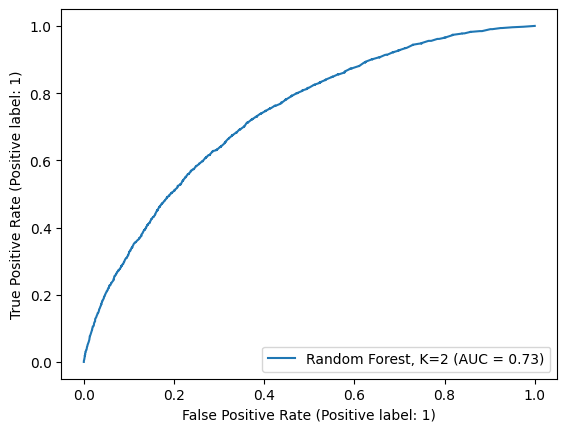

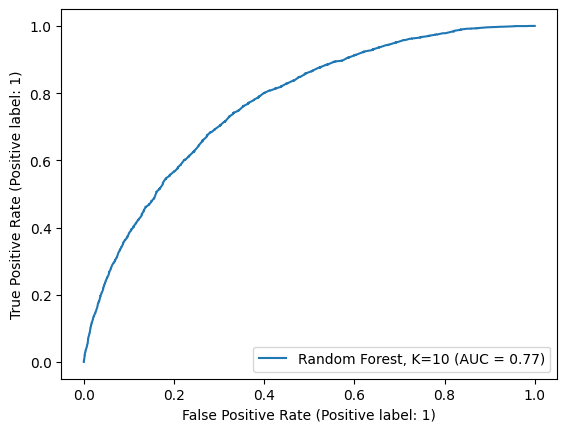

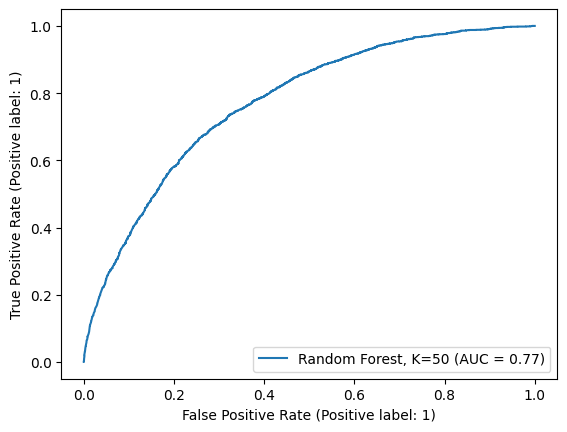

In [12]:
from sklearn.metrics import RocCurveDisplay

 
RocCurveDisplay.from_estimator(forest_2K, features_2K_test, ratings_2K_test, name="Random Forest, K=2")
RocCurveDisplay.from_estimator(forest_10K, features_10K_test, ratings_10K_test, name="Random Forest, K=10")
RocCurveDisplay.from_estimator(forest_50K, features_50K_test, ratings_50K_test, name="Random Forest, K=50")

In [28]:
from sklearn.metrics import roc_auc_score

print("num classes:", forest_2K.classes_)
yhat_forest_2K = forest_2K.predict_proba(features_2K_test)[:,1]
yhat_forest_10K = forest_10K.predict_proba(features_10K_test)[:,1]
yhat_forest_50K = forest_50K.predict_proba(features_50K_test)[:,1]
forest_2K_auc = roc_auc_score(ratings_2K_test, yhat_forest_2K)
forest_10K_auc = roc_auc_score(ratings_10K_test, yhat_forest_10K)
forest_50K_auc = roc_auc_score(ratings_50K_test, yhat_forest_50K)

yhat_knn_2K = knn_2K.predict_proba(features_2K_test)[:,1]
yhat_knn_10K = knn_10K.predict_proba(features_10K_test)[:,1]
yhat_knn_50K = knn_50K.predict_proba(features_50K_test)[:,1]
knn_2K_auc = roc_auc_score(ratings_2K_test, yhat_knn_2K)
knn_10K_auc = roc_auc_score(ratings_10K_test, yhat_knn_10K)
knn_50K_auc = roc_auc_score(ratings_50K_test, yhat_knn_50K)

scores = pd.DataFrame(
    [
        ["Random Forest", forest_2K_auc, forest_10K_auc, forest_50K_auc],
        ["KNN", knn_2K_auc, knn_10K_auc, knn_50K_auc],
    ],
    columns=["Classifier", "K=2", "K=10", "K=50"],
)

print(scores.to_string(index=False))

num classes: [0 1]


NameError: name 'knn_2K' is not defined

In [44]:
masked_test_df = pd.read_csv("data_movie_lens_100k/ratings_masked_leaderboard_set.csv")

user_ids = masked_test_df["user_id"].values
item_ids = masked_test_df["item_id"].values

def get_features_for_user(user_id):
    user_info = users_df[users_df["user_id"] == user_id]
    return user_info[["age", "is_male"]].values


def get_features_for_item(item_id):
    item_info = movies_df[movies_df["item_id"] == item_id]
    return item_info[["release_year"]].values

features = []
user_vectors = svd_50K.pu
item_vectors = svd_50K.qi

print(user_ids)

for i in range(len(user_ids)):
    user_id = user_ids[i]
    item_id = item_ids[i]

    try:
        u_i = user_vectors[user_id]
    except IndexError:
        u_i = np.zeros_like(user_vectors[0])
    try:
        m_j = item_vectors[item_id]
    except IndexError:
        m_j = np.zeros_like(item_vectors[0])
    
    user_features = get_features_for_user(user_id)
    item_features = get_features_for_item(item_id)
    
    feature_vector = np.concatenate(
            (
                u_i,
                m_j,
                user_features.flatten(),
                item_features.flatten(),
            )
        )
    features.append(feature_vector)


[503 795  42 ... 763 499 654]


In [41]:
# leaderboard_df = pd.read_csv('./data_movie_lens_100k/ratings_masked_leaderboard_set.csv')

# data_tuple = (
#         leaderboard_df['user_id'].values,
#         leaderboard_df['item_id'].values,
#         leaderboard_df['rating'].values)


# leaderboard_trainset = tuple_to_surprise_dataset(data_tuple).build_full_trainset()
# features, _ = get_feature_vectors(data_tuple, svd_50K, leaderboard_trainset)
# print(features)

[[ 2.41747314e-01 -1.96568367e-01 -3.14422896e-01 ...  4.00000000e+01
   0.00000000e+00  1.97000000e+03]
 [ 1.03322112e-01 -2.73139441e-01 -1.32978280e-01 ...  3.20000000e+01
   0.00000000e+00  1.98000000e+03]
 [ 2.63476439e-01  3.55012132e-02 -1.44576592e-01 ...  2.90000000e+01
   0.00000000e+00  1.99600000e+03]
 ...
 [-1.22459428e-01  1.54725570e-01 -4.24433975e-03 ...  2.70000000e+01
   0.00000000e+00  1.98400000e+03]
 [-1.70162830e-01 -1.04107945e-01  8.88126422e-02 ...  2.80000000e+01
   1.00000000e+00  1.98900000e+03]
 [ 5.02059120e-02  6.13247511e-03  2.02296928e-01 ...  5.00000000e+01
   0.00000000e+00  1.99700000e+03]]


In [45]:
print(np.array(features).shape)

(10000, 103)


In [46]:
yhat = forest_50K.predict(features)

print(yhat)

with open("predicted_ratings_leaderboard_new.txt", "w") as f:
    for y in yhat:
        f.write(f"{y}\n")

[0 0 0 ... 0 1 0]
